### **Setup**

In [167]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotProgress, plotProgressNetworkMulti, \
    plotResultsDots, plotIsolines, plotConfusionMatrixOCR, plotResultsDotsGradient
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

### **Multi-layer neural network**

In this notebook, a multi layer neural network is implemented and used to classify instances of four different datasets.

The training of the network includes three parts that are devided into different functions; the forward pass, the backward pass and the weight update. 

#### **Implementing the forward pass**

The function preforms one forward pass of the single layer network. It takes input samples, calculates the output for each sample using the provided weights and biases, and returns both the raw output and the resulting label for each sample.

In [168]:
def forward(X, W1, B1, W2, B2, useTanhOutput=False):
    """Forward pass of two layer network

    Args:
        X (array): Input samples.
        W1 (array): First layer neural network weights.
        B1 (array): First layer neural network biases.
        W2 (array): Second layer neural network weights.
        B2 (array): Second layer neural network biases.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
        U (array): Output of hidden layer.
    """

    #first (hidden) layer
    U = X @ W1 + B1
    
    if useTanhOutput:
        U = np.tanh(U)

    Y = U @ W2 + B2
    
    # Calculate labels
    L = Y.argmax(axis=1)

    return Y, L, U

#### **Implementing the backward pass**

This function computes gradients for the network weights and biases with respect to the loss function based on predicted and target outputs, considering whether the network utilizes a tanh activation function on its output layer, returning these gradients for parameter updates.

In [197]:
def backward(W1, B1, W2, B2, X, U, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        X (array): Training samples.
        U (array): Intermediate outputs of the hidden layer.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool): (optional)
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
        
    Returns:
        GradW1 (array): Gradients with respect to W1
        GradB1 (array): Gradients with respect to B1
        GradW2 (array): Gradients with respect to W2
        GradB2 (array): Gradients with respect to B2
    """
    
    N  = Y.shape[0]
    NC = Y.shape[1]

    matrix1 = np.ones((1, len(Y)))

    GradW2 = 2 * U.T @ (Y - D) / (N * NC)
    GradB2 = 2 * matrix1 @ (Y - D) / (N * NC)

    if useTanhOutput:
        GradW1 = 2 * X.T @ (( Y - D) @ W2.T * ( 1 - (U **2))) / (N * NC)
        GradB1 = 2 * matrix1 @ (( Y - D) @ W2.T * ( 1 - (U **2))) / (N * NC)

    else:
        GradW1 = 2 * X.T @ (( Y - D) @ W2.T ) / (N * NC)
        GradB1 = 2 * matrix1 @ (( Y - D) @ W2.T) / (N * NC)

    
    return GradW1, GradB1, GradW2, GradB2

#### **Implementing the weight update**

This function updates and returns the new weights and biases using gradient descent.

In [198]:
def update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params):
    """Update weights and biases using computed gradients.

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        
        GradW1 (array): Gradients with respect to W1.
        GradB1 (array): Gradients with respect to B1.
        GradW2 (array): Gradients with respect to W2.
        GradB2 (array): Gradients with respect to B2.
        
        params (dict):
            - learningRate: Scale factor for update step.
            - momentum: Scale factor for momentum update (optional).
        
    Returns:
        W1 (array): Updated layer 1 weights.
        B1 (array): Updated layer 1 biases.
        W2 (array): Updated layer 2 weights.
        B2 (array): Updated layer 2 biases.
    """
    
    LR = params["learningRate"]
    
    # Update weights
    W1 = W1 - LR * GradW1
    B1 = B1 - LR * GradB1
    W2 = W2 - LR * GradW2
    B2 = B2 - LR * GradB2

    
    return W1, B1, W2, B2
    

#### **1.4 The training function**

The given training function trains the multi-layer neural network with given data and parameters, iteratively updating weights and biases, evaluating performance, and returning the trained parameters along with metrics such as losses and accuracies for training and test data. The network is trained for a specified number of epochs while tracking and plotting the training process.

In [199]:
def trainMultiLayer(XTrain, DTrain, XTest, DTest, W1_0, B1_0, W2_0, B2_0, params):
    """Trains a two-layer network

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training network target values.
        XTest (array): Test samples.
        DTest (array): Test network target values.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.

    Returns:
        W1 (array): First layer weights after training.
        B1 (array): Fisrt layer biases after training.
        W2 (array): Second layer weights after training.
        B2 (array): Second layer biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}

    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False
        
    if "momentum" not in params:
        params["momentum"] = 0       
    
    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]
    nClasses = DTrain.shape[1]
    
    # Set initial weights
    W1 = W1_0
    B1 = B1_0
    W2 = W2_0
    B2 = B2_0
    
    # For optional task on momentum
    params["PrevGradW1"] = np.zeros_like(W1)
    params["PrevGradB1"] = np.zeros_like(B1)
    params["PrevGradW2"] = np.zeros_like(W2)
    params["PrevGradB2"] = np.zeros_like(B2)

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
    YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan # ((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan # ((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan # (LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan # (LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    fig = plt.figure(figsize=(20,8), tight_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # Compute gradients...
        GradW1, GradB1, GradW2, GradB2 = backward(W1, B1, W2, B2, XTrain, UTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W1, B1, W2, B2 = update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params)
        
        # Evaluate errors
        YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
        YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (plotProgress and not n % 500) or n == params["epochs"]:
            if W1.shape[0] == 2 and W1.shape[1] <= 8:
                plotProgressNetworkMulti(fig, W1, B1, W2, B2, metrics, n=n)
            else:
                plotProgress(fig, metrics, n)

    return W1, B1, W2, B2, metrics

The following function normalize the input data, this to improve the network's preformance, avoid certain features to dominate the learning process and to reduce the the vanishing gradient problem.

In [200]:
def normalize(X):
    # Compute mean and std
    m = X.mean(axis=0)
    s = X.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

---
### **Optimizing each dataset**

This function simplifies the training of the multi-layer neural network on a specific dataset. The functions begins with the loading of the data and splitting it into train and test datasets. Optionally, it normalizes the data if specified in the parameters. It then trains the network using the provided initial weights and biases and evaluates its performance on the test set by computing accuracy and confusion matrix. Finally, it displays the results and visualizes the network's output.

In [201]:
def  trainMultiLayerOnDataset(datasetNr, testSplit, W1_0, B1_0, W2_0, B2_0, params):
    """Train a two layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            nIterations (int): Number of training steps.
            learningRate (float): Size of a training step.
    """
    
    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)
    
    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain)
        XTestNorm  = normalize(XTest)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest

    # Train network
    W1, B1, W2, B2, metrics = trainMultiLayer(XTrainNorm, DTrain, XTestNorm, DTest, W1_0, B1_0, W2_0, B2_0, params)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W1, B1, W2, B2, params["useTanhOutput"])[1]
    LPredTest  = forward(XTestNorm , W1, B1, W2, B2, params["useTanhOutput"])[1]

    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest  = calcAccuracy(LPredTest , LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)

    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        # Switch between these two functions to see another way to visualize the network output.
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[1])
        #plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[0])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **Optimizing dataset 1**

Train accuracy: 0.9888
Test accuracy: 0.9967
Test data confusion matrix:
[[148.   0.]
 [  1. 151.]]


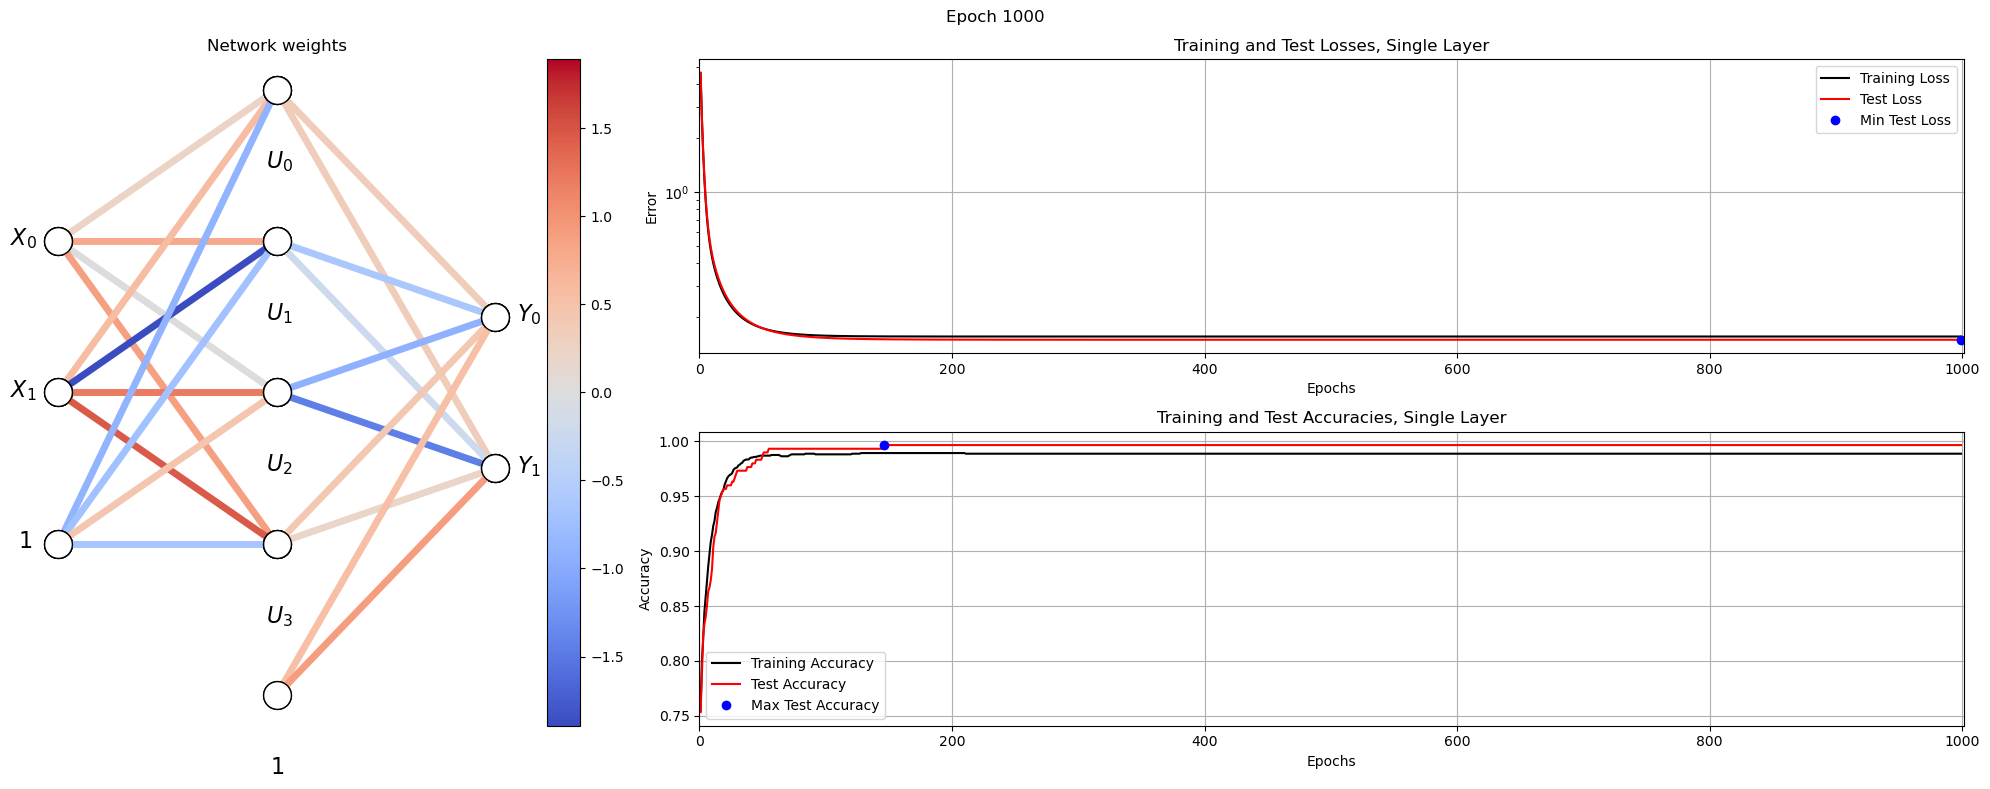

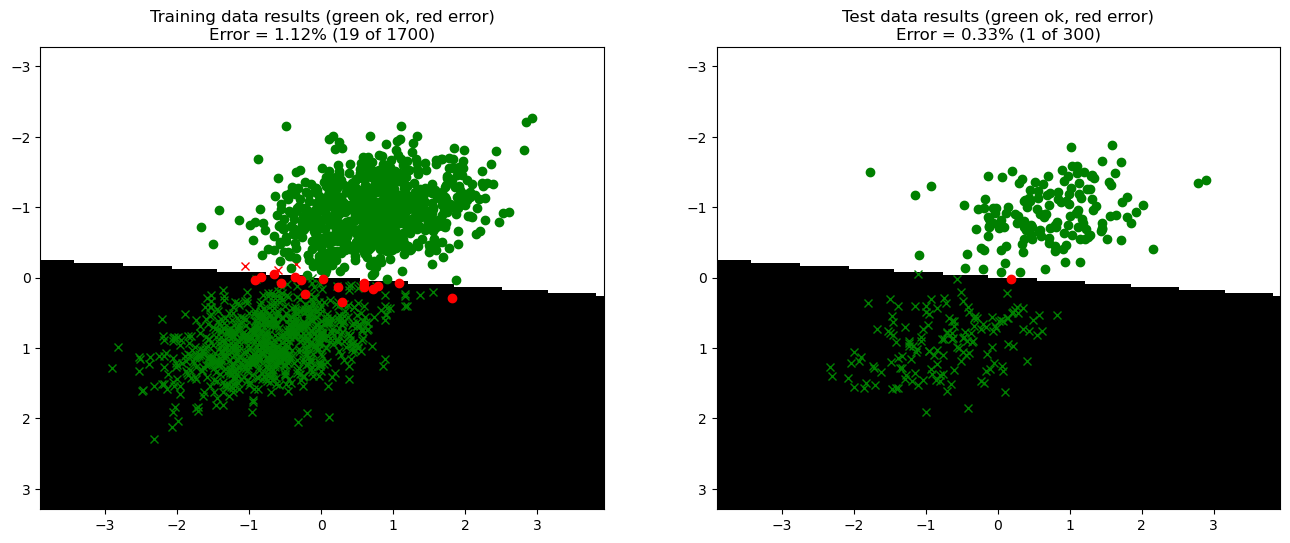

In [212]:
nInputs  = 2
nClasses = 2
nHidden = 4

W1_0 = np.random.randn(nInputs, nHidden)
B1_0 = np.random.randn(1, nHidden)
#B1_0 = B1_0.reshape(-1, 1)

W2_0 = np.random.randn(nHidden, nClasses)
B2_0 = np.random.randn(1, nClasses)
#B2_0 = B2_0.reshape(-1, 1)

params = {"epochs": 1000, "learningRate": 0.05, "normalize": True, "useTanhOutput": False}

trainMultiLayerOnDataset(1, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **Optimizing dataset 2**

Train accuracy: 0.9965
Test accuracy: 1.0000
Test data confusion matrix:
[[154.   0.]
 [  0. 146.]]


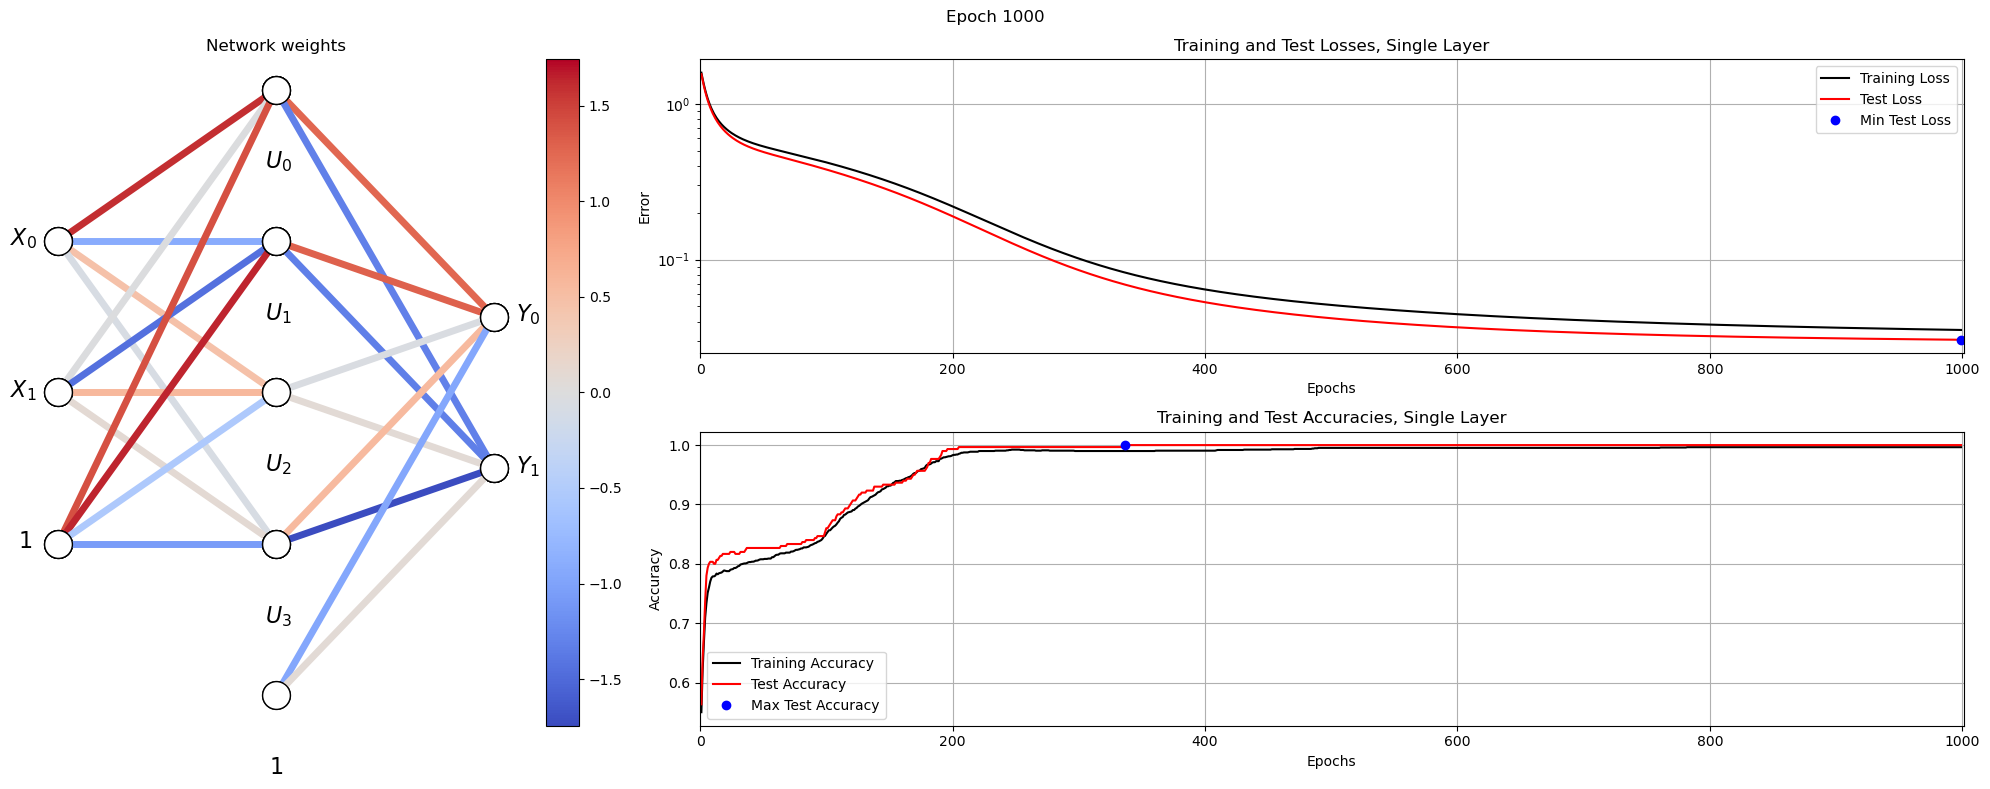

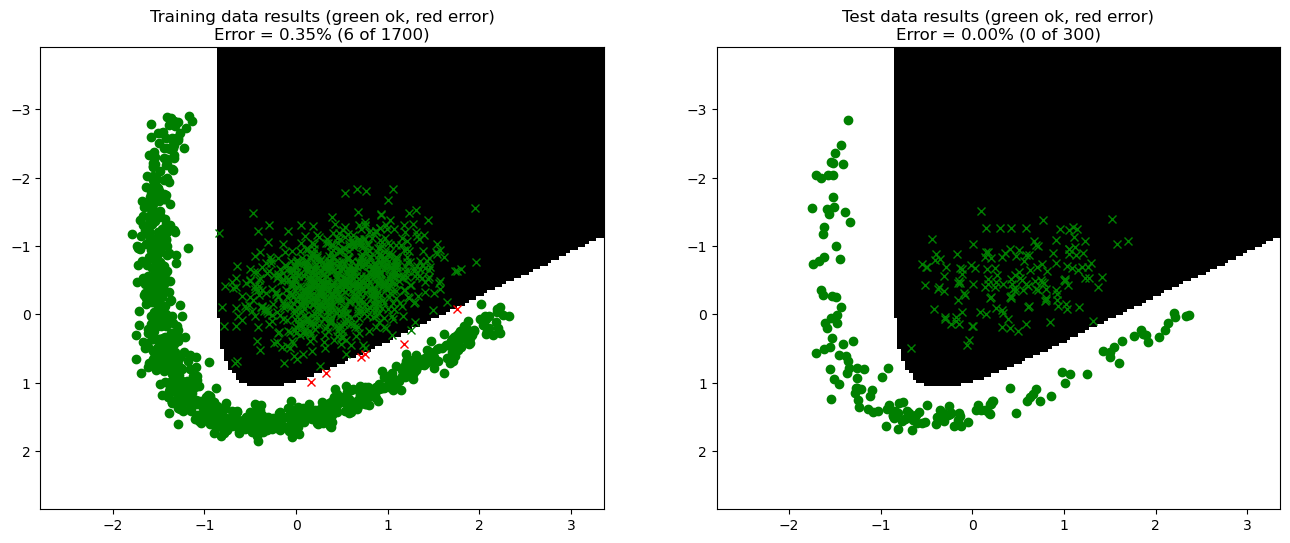

In [217]:
nInputs  = 2
nClasses = 2
nHidden  = 4

W1_0 = np.random.randn(nInputs, nHidden)
B1_0 = np.random.randn(1, nHidden)

W2_0 = np.random.randn(nHidden, nClasses)
B2_0 = np.random.randn(1, nClasses)



params = {"epochs": 1000, "learningRate": 0.05, "normalize": True, "useTanhOutput": True}

trainMultiLayerOnDataset(2, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **Optimizing dataset 3**

Train accuracy: 0.9565
Test accuracy: 0.9300
Test data confusion matrix:
[[ 91.   6.   3.]
 [ 12. 102.   0.]
 [  0.   0.  86.]]


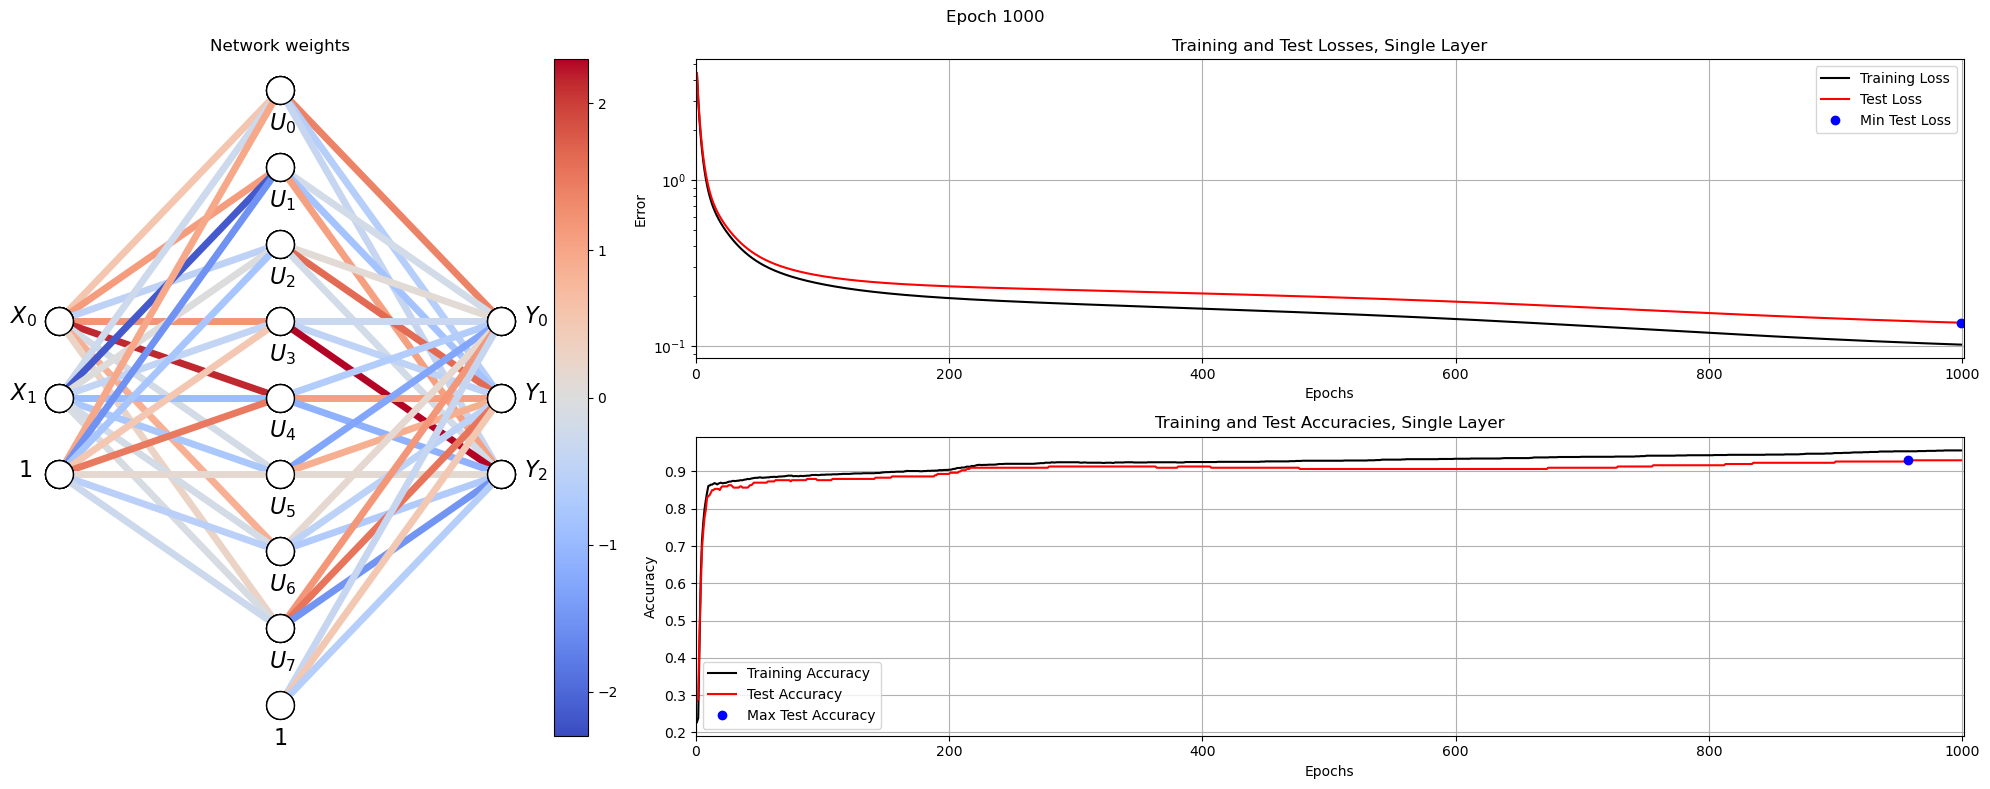

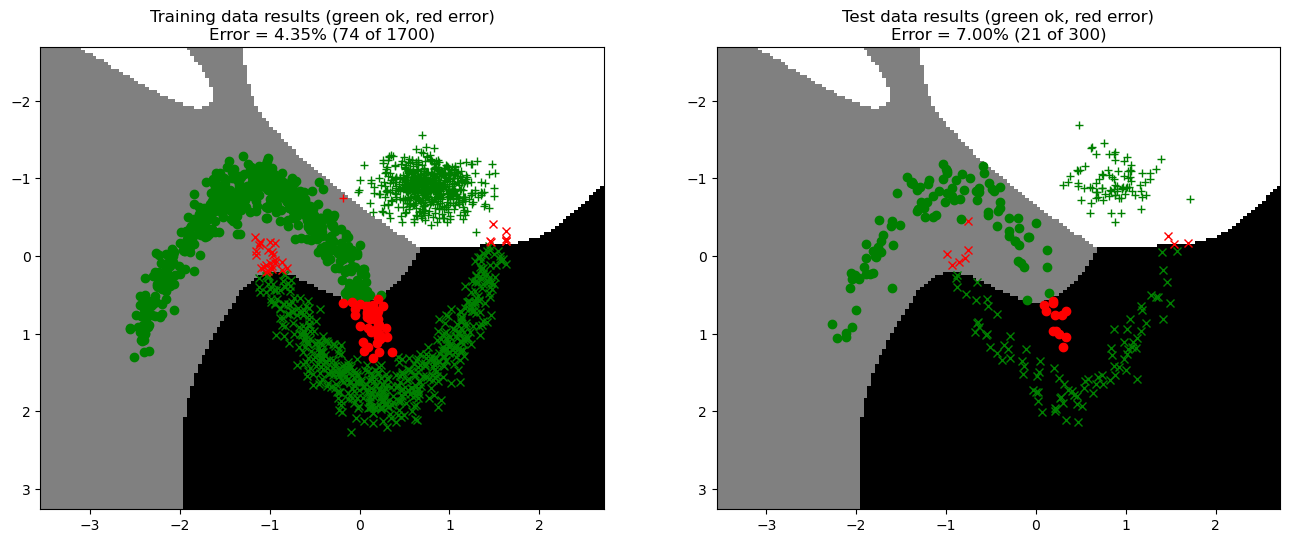

In [224]:
nInputs  = 2
nClasses = 3
nHidden  = 8

W1_0 = np.random.randn(nInputs, nHidden)
B1_0 = np.random.randn(1, nHidden)

W2_0 = np.random.randn(nHidden, nClasses)
B2_0 = np.random.randn(1, nClasses)

params = {"epochs": 2000, "learningRate": 0.1, "normalize": True, "useTanhOutput": True}

trainMultiLayerOnDataset(3, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **Optimizing dataset 4**

Train accuracy: 0.9722
Test accuracy: 0.9668
Test data confusion matrix:
[[93.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 72.  2.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0. 90.  0.  0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1. 88.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 74.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 83.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 81.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. 81.  0.  2.]
 [ 0.  4.  0.  0.  3.  0.  1.  0. 76.  1.]
 [ 1.  1.  0.  1.  0.  0.  0.  2.  0. 77.]]


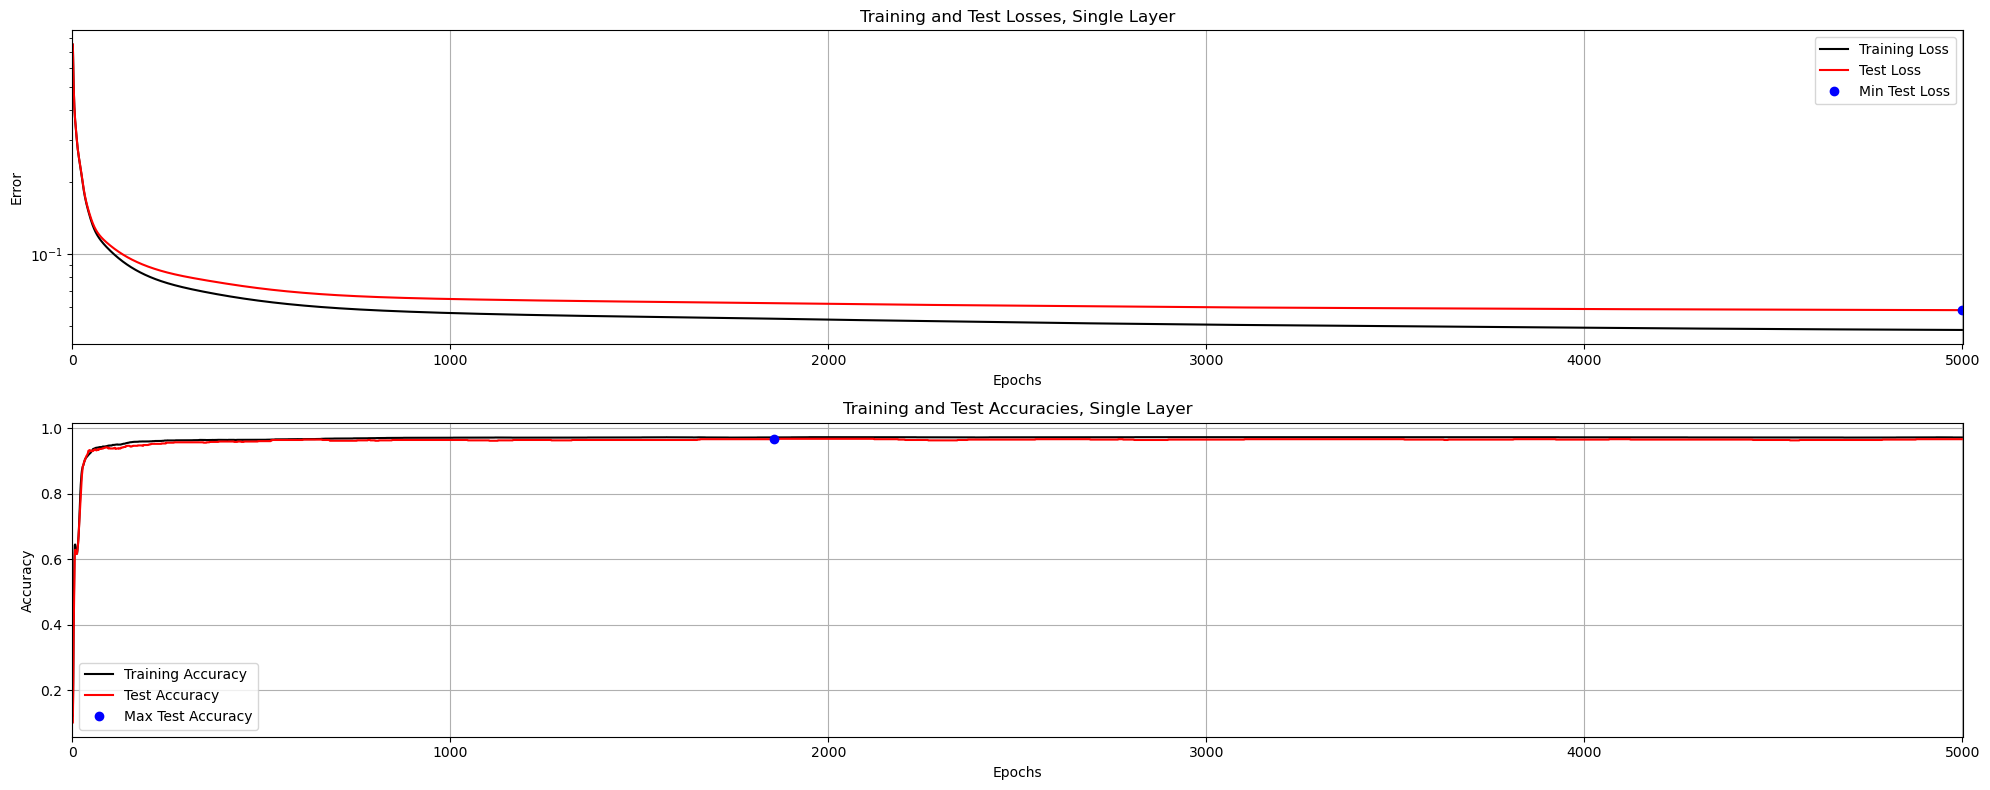

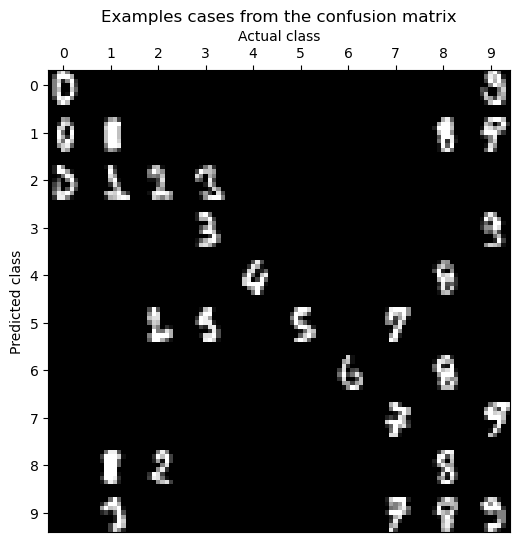

In [272]:
nInputs  = 64
nClasses = 10
nHidden  = 15

W1_0 = np.random.randn(nInputs, nHidden) / 100
B1_0 = np.random.randn(1, nHidden) / 100

W2_0 = np.random.randn(nHidden, nClasses) / 100
B2_0 = np.random.randn(1, nClasses) / 100

params = {"epochs": 5000, "learningRate": 1.0, "normalize": True, "useTanhOutput": True}

trainMultiLayerOnDataset(4, 0.15, W1_0, B1_0, W2_0, B2_0, params)